In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 master

--2023-04-28 08:01:46--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2820 (2.8K) [text/plain]
Saving to: ‘icevision_install.sh.3’

icevision_install.s 100%[===================>]   2.75K  --.-KB/s    in 0s      

2023-04-28 08:01:46 (38.0 MB/s) - ‘icevision_install.sh.3’ saved [2820/2820]

Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.10.0+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.

In [ ]:
pip install wandb -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import wandb
import torchvision.models as tvmodels
import pandas as pd
from icevision.all import *

import params

from train import (
    select_model,
    download_data,
    get_data,
    COCOMetric_Chair,
    COCOMetric_Couch,
    COCOMetric_TV,
    COCOMetric_Remote,
    COCOMetric_Book,
    COCOMetric_Vase,
)

/home/pmonniot/anaconda3/envs/wandb-ice/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/pmonniot/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/pmonniot/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


In [2]:
run = wandb.init(
    project=params.WANDB_PROJECT,
    entity=params.ENTITY,
    job_type="evaluation",
    tags=["staging"],
)

artifact = run.use_artifact("pmon/model-registry/assignment2-model:v0", type="model")

artifact_dir = Path(artifact.download())

_model_pth = artifact_dir.ls()[0]
model_path = _model_pth.parent.absolute() / _model_pth.stem

producer_run = artifact.logged_by()
wandb.config.update(producer_run.config)
config = wandb.config



04/28/2023 10:28:49 - ERROR - wandb.jupyter -   Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmon. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [4]:
model = torch.load(model_path)
torch.save(model, 'model.pth')

In [5]:
from fastai.torch_core import set_seed
def eval(config, processed_dataset_dir=None, model_path=None):
    set_seed(config.seed, reproducible=True)
    if processed_dataset_dir is None:
        processed_dataset_dir = download_data()
    _, val_ds, parser, test_ds = get_data(
        processed_dataset_dir,
        bs=config.batch_size,
        image_size=config.img_size,
        augment=config.augment,
    )
    metrics = [
        COCOMetric_Chair(),
        COCOMetric_Couch(),
        COCOMetric_TV(),
        COCOMetric_Remote(),
        COCOMetric_Book(),
        COCOMetric_Vase(),
        COCOMetric(metric_type=COCOMetricType.bbox),
    ]
    model_type, backbone, extra_args = select_model(config.arch, config.img_size)
    model = model_type.model(
        backbone=backbone(pretrained=True),
        num_classes=len(parser.class_map),
        **extra_args,
    )
    # Data Loaders
    # TODO: Change to have test instead
    val_dl = model_type.valid_dl(
        val_ds, batch_size=config.batch_size, num_workers=10, shuffle=True
    )
    test_dl = model_type.valid_dl(
        test_ds, batch_size=config.batch_size, num_workers=10, shuffle=True
    )

    learn = model_type.fastai.learner(
        dls=[test_dl,val_dl],
        model=model,
        metrics=metrics
    )
    learn.load(model_path)
    # Infer
    infer_dl = model_type.infer_dl(
        val_ds, batch_size=config.batch_size, shuffle=False
    )
    preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)
    return learn, preds
    

In [9]:
try:
  learn, preds = eval(config, Path("/content/artifacts/kaggle_obj_det_split:v0"), Path("/content/model"))
except:
  learn, preds = eval(config, None, "model")

wandb: Downloading large artifact kaggle_obj_det_split:latest, 12833.47MB. 43676 files... 
wandb:   43676 of 43676 files downloaded.  
Done. 0:0:38.8
100%|██████████| 87106/87106 [00:05<00:00, 15277.74it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:122
100%|██████████| 21837/21837 [00:24<00:00, 887.87it/s]
/home/pmonniot/anaconda3/envs/wandb-ice/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")
  0%|          | 0/273 [00:00<?, ?it/s]/home/pmonniot/anaconda3/envs/wandb-ice/lib/python3.9/site-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floo

In [10]:
val_metrics = learn.validate(ds_idx=1)
test_metrics = learn.validate(ds_idx=0)

In [11]:
val_metric_names = ['val_loss'] + [f'val_{x.name}' for x in learn.metrics]
val_results = {val_metric_names[i] : val_metrics[i] for i in range(len(val_metric_names))}

In [12]:
val_results

{'val_loss': 0.7364104390144348,
 'val_COCOMetric_Chair': 0.13012077931032845,
 'val_COCOMetric_Couch': 0.32989322244790015,
 'val_COCOMetric_TV': 0.41397405507256796,
 'val_COCOMetric_Remote': 0.052273722149459405,
 'val_COCOMetric_Book': 0.03256902594870187,
 'val_COCOMetric_Vase': 0.1735922608701194,
 'val_COCOMetric': 0.18873717763317951}

In [16]:
for k,v in val_results.items(): 
    wandb.summary[k] = v

In [17]:
test_metric_names = ['test_loss'] + [f'test_{x.name}' for x in learn.metrics]
test_results = {test_metric_names[i] : test_metrics[i] for i in range(len(test_metric_names))}
for k,v in test_results.items(): 
    wandb.summary[k] = v

In [15]:
np.mean([0.121, 0.181,.145,0.013,.214,.316,.123,.139,.01,.244,.392])

0.17254545454545456

In [ ]:
metric = COCOMetric(metric_type=COCOMetricType.bbox)

In [ ]:
metric.accumulate(preds)

In [ ]:
coco_eval = create_coco_eval(
                records=metric._records,
                preds=metric._preds,
                metric_type=metric.metric_type.value,
                iou_thresholds=metric.iou_thresholds,
                show_pbar=metric.show_pbar,
            )

creating index...
index created!
creating index...
index created!


In [ ]:
coco_eval.evaluate()
coco_eval.accumulate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.84s).
Accumulating evaluation results...
DONE (t=0.45s).


In [ ]:
coco_eval.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.392


In [ ]:
metric.print_summary()

TypeError: ignored

In [ ]:
coco_eval_chair = create_coco_eval(
                records=metric._records,
                preds=metric._preds,
                metric_type=metric.metric_type.value,
                iou_thresholds=metric.iou_thresholds,
                show_pbar=metric.show_pbar,
            )
coco_eval.params.catIds = 1
coco_eval.evaluate()
coco_eval.accumulate()

In [ ]:
coco_eval_chair = create_coco_eval(
                records=metric._records,
                preds=metric._preds,
                metric_type=metric.metric_type.value,
                iou_thresholds=metric.iou_thresholds,
                show_pbar=metric.show_pbar,
            )
coco_eval_chair.params.catIds = 1
coco_eval_chair.evaluate()
coco_eval_chair.accumulate()

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.53s).
Accumulating evaluation results...
DONE (t=0.08s).


In [ ]:
coco_eval_chair.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.223
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.267


In [ ]:
        COCOMetric_Chair(),
        COCOMetric_Couch(),
        COCOMetric_TV(),
        COCOMetric_Remote(),
        COCOMetric_Book(),
        COCOMetric_Vase(),

In [ ]:
def bounding_boxes(pred):
    # load raw input photo
    all_boxes_pred = []
    all_boxes_gt = []
    image = pred.as_dict()["common"]["img"]
    (height, width, _) = image.shape
    classes = pred.detection.class_map._id2class
    class_labels = {idx: classes[idx] for idx in range(len(classes))}
    # plot each bounding box for this image
    for box, class_lbl in zip(pred.pred.detection.bboxes, pred.pred.detection.label_ids):
        # get coordinates and labels
        box_data = {"position" : {
          "minX" : np.float64(box.xmin)/width,
          "maxX" : np.float64(box.xmax)/width,
          "minY" : np.float64(box.ymin)/height,
          "maxY" : np.float64(box.ymax)/height},
          #boxes in coco [x_min, y_min, width, height]
          "class_id" : int(class_lbl)}
          # optionally caption each box with its class and score
          # "box_caption" : "%s (%.3f)" % (v_labels[b_i], v_scores[b_i]),
          # "domain" : "pixel",
          # "scores" : { "score" : v_scores[b_i] }}
        all_boxes_pred.append(box_data)
    for box, class_lbl in zip(pred.ground_truth.detection.bboxes, pred.ground_truth.detection.label_ids):
        # get coordinates and labels
        box_data = {"position" : {
          "minX" : np.float64(box.xmin)/width,
          "maxX" : np.float64(box.xmax)/width,
          "minY" : np.float64(box.ymin)/height,
          "maxY" : np.float64(box.ymax)/height},
          #boxes in coco [x_min, y_min, width, height]
          "class_id" : int(class_lbl)}
          # optionally caption each box with its class and score
          # "box_caption" : "%s (%.3f)" % (v_labels[b_i], v_scores[b_i]),
          # "domain" : "pixel",
          # "scores" : { "score" : v_scores[b_i] }}
        all_boxes_gt.append(box_data)

    # log to wandb: raw image, predictions, and dictionary of class labels for each class id
    box_image = wandb.Image(image, boxes = {"predictions": {"box_data": all_boxes_pred, "class_labels" : class_labels}, "ground_truth": {"box_data": all_boxes_gt, "class_labels" : class_labels}})
    return box_image

In [ ]:
preds[0].ground_truth.detection.label_ids.count(0)

0

In [ ]:
coco_eval

12

In [ ]:
iou_dict = coco_eval.ious
labels = ['chair', 'couch', 'tv', 'remote', 'book', 'vase']
table = wandb.Table(columns=["File_Name", "Images"] + labels)
for record in preds:
  file = record.pred.filepath.name
  image = bounding_boxes(record)
  ious = []
  for i in range(1,7):
    if len(iou_dict[(file,i)])>0:
      ious.append(iou_dict[(file,i)].mean())
    elif record.ground_truth.detection.label_ids.count(i)>0:
      ious.append(0)
    else:
      ious.append(np.nan)
  table.add_data(
            str(file),
            image,
            *ious
        )

In [ ]:
val_metric_names = ['val_loss'] + [f'val_{x.name}' for x in learn.metrics]

In [ ]:
val_metrics = learn.validate(ds_idx=1, dl=)

/usr/local/lib/python3.9/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


KeyError: ignored

In [ ]:
val_metric_names

['val_loss',
 'val_COCOMetric_Chair',
 'val_COCOMetric_Couch',
 'val_COCOMetric_TV',
 'val_COCOMetric_Remote',
 'val_COCOMetric_Book',
 'val_COCOMetric_Vase',
 'val_COCOMetric']

In [ ]:
val_results = {val_metric_names[i] : val_metrics[i] for i in range(len(val_metric_names))}

NameError: ignored

In [ ]:
iou_dict[("000000096251.jpg",6)].max(1)

array([    0.86895,     0.78307,    0.016518])

In [ ]:
data.keys()

dict_keys(['_type', 'column_types', 'columns', 'data', 'ncols', 'nrows'])

In [ ]:
error_analysis = wandb.Artifact("error_analysis", type="raw_data")

In [ ]:
error_analysis.add(table, "error_table")

ArtifactManifestEntry(path='error_table.table.json', digest='S/INzEpa2Af4SiBuX1Mmnw==', ref=None, birth_artifact_id=None, size=2269047, extra={}, local_path='/root/.local/share/wandb/artifacts/staging/tmpicmpek7f')

In [ ]:
run.log_artifact(error_analysis)
run.finish()

In [ ]:
count=0
for predict in preds:
  label_pred = predict.pred.detection.labels
  label_gt = predict.ground_truth.detection.labels[:len(label_pred)]
  if label_pred!=label_gt:
    print("label_pred: ",label_pred)
    print("label_gt: ",predict.ground_truth.detection.labels)
    print(predict.pred.detection.scores)
    print()
  count+=1
print(count)

In [ ]:
preds[71].pred.detection.class_map.__dict__

{'_lock': True,
 '_id2class': ['background', 'chair', 'couch', 'tv', 'remote', 'book', 'vase'],
 '_background': 'background',
 '_class2id': {'background': 0,
  'chair': 1,
  'couch': 2,
  'tv': 3,
  'remote': 4,
  'book': 5,
  'vase': 6}}

In [ ]:
preds[71].ground_truth.img

In [ ]:
preds[71].ground_truth.filepath.name

In [ ]:
preds[4].ground_truth.detection

In [ ]:
coco_eval.ious

In [ ]:
for key,value in coco_eval.ious.items():
  print(key)
  print(value)

  break

('000000000564.jpg', 1)
[]


In [ ]:
coco_eval.ious[('000000047137.jpg', 4)].mean()

AttributeError: ignored

In [ ]:
labels = ['background', 'chair', 'couch', 'tv', 'remote', 'book', 'vase']
table = wandb.Table(columns=["File_Name", "Images"] + labels)
count=0
for key, value in coco_eval.ious.items():
  if count%6==0:
    if count!=0:
      table.add_data(
          file,
          
      )
    file=key[0]
    ious=[]
  if len(value)>0:
    ious.append(value.mean())
  else:
    iou.append(np.nan)


In [ ]:
def compute_iou(bbox_pred, bbox_gt):
  xmin1= bbox_pred.xmin
  ymin1= bbox_pred.ymin
  xmax1= bbox_pred.xmax
  ymax1= bbox_pred.ymax

  xmin2= bbox_gt.xmin
  ymin2= bbox_gt.ymin
  xmax2= bbox_gt.xmax
  ymax2= bbox_gt.ymax

  xmin = max(xmin1, xmin2)
  ymin = max(ymin1, ymin2)
  xmax = min(xmax1, xmax2)
  ymax = min(ymax1, ymax2)
  intersection_area = (xmax - xmin) * (ymax - ymin)
  area1 = (xmax1 - xmin1) * (ymax1 - ymin1)
  area2 = (xmax2 - xmin2) * (ymax2 - ymin2)
  union_area = area1 + area2 - intersection_area
  return intersection_area/union_area

def iou_per_class(pred, gt):
  iou_scores = []
  classes = pred.detection.class_map
  for c in pred.detection.class_map._id2class[1:-1]:
    max_iou = 0
    

In [ ]:
xmin1=155.93599999999998
ymin1=129.452
xmax1=256.0
ymax1=212.144

xmin2=156.36813354492188
ymin2=131.0994415283203
xmax2=255.71478271484375
ymax2=210.39906311035156

In [ ]:
xmin = max(xmin1, xmin2)
ymin = max(ymin1, ymin2)
xmax = min(xmax1, xmax2)
ymax = min(ymax1, ymax2)
intersection_area = (xmax - xmin) * (ymax - ymin)

In [ ]:
area1 = (xmax1 - xmin1) * (ymax1 - ymin1)
area2 = (xmax2 - xmin2) * (ymax2 - ymin2)
union_area = area1 + area2 - intersection_area

In [ ]:
intersection_area/union_area

0.95210091573145

In [ ]:
dir(preds[0].pred)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_component',
 'aggregate_objects',
 'as_dict',
 'autofix',
 'base_components',
 'builder_template',
 'check_num_annotations',
 'components',
 'filepath',
 'height',
 'load',
 'num_annotations',
 'record_id',
 'reduce_on_components',
 'reduce_on_task_components',
 'remove_annotation',
 'remove_component_by_type',
 'set_task_components',
 'setup_transform',
 'task_composites',
 'unload',
 'width']

In [ ]:
inp = preds[0].preds
targ = preds[0].ground_truth

In [ ]:
create_coco_eval([preds[4].pred], [preds[4].ground_truth], "bbox")

AttributeError: ignored

In [ ]:
def create_coco_eval(
    records,
    preds,
    metric_type: str,
    iou_thresholds: Optional[Sequence[float]] = None,
    show_pbar: bool = False,
) -> COCOeval:
    assert len(records) == len(preds)

    for record, pred in zip(records, preds):
        pred.record_id = record.record_id
        pred.height = record.height
        pred.width = record.width
        # needs 'filepath' for mask `coco.py#418`

    target_ds = coco_api_from_records(records, show_pbar=show_pbar)
    pred_ds = coco_api_from_preds(preds, show_pbar=show_pbar)

    coco_eval = COCOeval(target_ds, pred_ds, metric_type)
    if iou_thresholds is not None:
        coco_eval.iouThrs = iou_thresholds

    return coco_eval

NameError: ignored

In [ ]:
preds[0].pred

BaseRecord

common: 
	- Record ID: 000000193759.jpg
	- Image size ImgSize(width=256, height=256)
	- Img: 256x256x3 <np.ndarray> Image
detection: 
	- BBoxes: [<BBox (xmin:103.09483337402344, ymin:120.58033752441406, xmax:172.11058044433594, ymax:209.7259063720703)>]
	- Scores: [    0.64253]
	- Class Map: <ClassMap: {'background': 0, 'chair': 1, 'couch': 2, 'tv': 3, 'remote': 4, 'book': 5, 'vase': 6}>
	- Labels: [6]

In [ ]:
wandb.Image(preds[0].pred.img, boxes= {"predictions": {"box_data": preds[0].pred.detection.bboxes, "class_labels" : preds[0].pred.detection.labels}})

AttributeError: ignored

In [ ]:
def iou_per_class(inp, targ):
    "Compute iou per class"
    iou_scores = []
    for c in range(inp.shape[0]):
        dec_preds = inp.argmax(dim=0)
        p = torch.where(dec_preds == c, 1, 0)
        t = torch.where(targ == c, 1, 0)
        c_inter = (p * t).float().sum().item()
        c_union = (p + t).float().sum().item()
        iou_scores.append(c_inter / (c_union - c_inter) if c_union > 0 else np.nan)
    return iou_scores

def create_row(pred, class_labels):
    """"A simple function to create a row of (img, target, prediction, and scores...)"""
    image = pred.ground_truth.Img
    label = pred.ground_truth.Labels
    prediction = pred.ground_truth.BBoxes
    # compute metrics
    iou_scores = iou_per_class(prediction, label)
    image = image.permute(1, 2, 0)
    row =[wandb.Image(
                image,
                masks={
                    "predictions": {
                        "mask_data": pred_label[0].numpy(),
                        "class_labels": class_labels,
                    },
                    "ground_truths": {
                        "mask_data": label.numpy(),
                        "class_labels": class_labels,
                    },
                },
            ),
            *iou_scores,
    ]
    return row


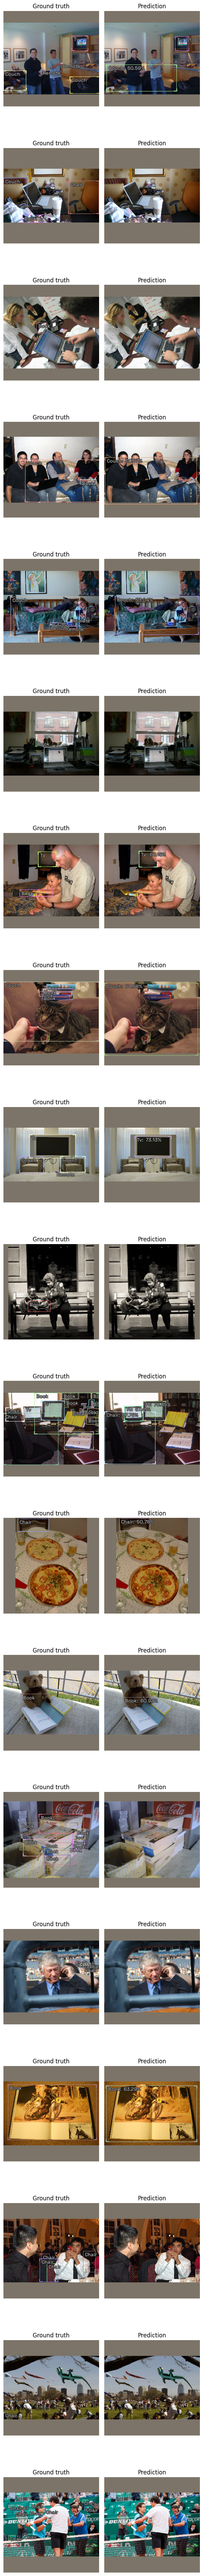

In [ ]:
show_preds(preds=preds[61:80])

In [ ]:
val_metrics = learn.validate()
test_metrics = learn.validate(ds_idx=0)

/usr/local/lib/python3.9/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


KeyError: ignored

> /usr/local/lib/python3.9/dist-packages/effdet/bench.py(143)forward()
    141             output['detections'] = _batch_detection(
    142                 x.shape[0], class_out_pp, box_out_pp, self.anchors.boxes, indices, classes,
--> 143                 target['img_scale'], target['img_size'],
    144                 max_det_per_image=self.max_det_per_image, soft_nms=self.soft_nms)
    145         return output

ipdb> q


In [ ]:
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

/usr/local/lib/python3.9/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


KeyError: ignored